In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import copy as cp
import importanceMatrix
import shap
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import scale
from matplotlib import pyplot as plt

proj_path = os.path.dirname(os.getcwd())
fig_path = proj_path + '/2_docs/LaTeX/Figures'
datasets = []

In [ ]:
# load JS visualization code to notebook
#shap.initjs()

In [4]:
def fit_RF(label, data, feature_names, class_col, class_names, class_tags, rnd_seed=45):
    X = np.array(data.loc[:,feature_names])
    y = np.array(data.loc[:,class_col])
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rnd_seed)

    # train the classifier
    rf_clf = RandomForestClassifier(random_state=rnd_seed, n_estimators=100)
    rf_clf.fit(X_train, y_train)

    # make predictions and calculate the MAE error
    predictions = rf_clf.predict(X_test)
    errors = abs(predictions - y_test)
    print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 

    # calculate the accuracy of the classifier
    acc = 100 * accuracy_score(y_test, predictions)
    print('Model Accuracy: {}'.format(round(acc, 2)))

    print(np.unique(y, return_counts=True))
    print(np.unique(y_train, return_counts=True))
    print(np.unique(y_test, return_counts=True))
    return np.array([rf_clf, feature_names, y, y_test, predictions, class_names])

def f_top5(rf_clf, feature_names, y):
    global_importance = rf_clf.feature_importances_
    global_index = np.argsort(global_importance)
    global_index = global_index[::-1]
    
    imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)
    mean_importance = np.mean(imp_mat, axis=0)
    pca_index = np.argsort(mean_importance)
    pca_index = pca_index[::-1]

    unique_classes, count_classes = np.unique(y, return_counts=True)
    is_balanced = all([i==j for i in count_classes for j in count_classes])
    rare_class_ind = np.argsort(count_classes)[0]
    rare_class = unique_classes[rare_class_ind]
    rare_class_index = np.argsort(imp_mat[rare_class_ind])
    rare_class_index = rare_class_index[::-1]
    
    ##FERMALI ALLA PRIMA ISTANZA DOVE DIFFERISCONO
    index = [i for i in np.arange(len(feature_names)) if global_index[i] != pca_index[i]]
    if len(index) == 0:
        print('FAIL')
        top5_global_features = feature_names[global_index[:3]]
        top5_pca_features = feature_names[pca_index[:3]]
        top5_rare_features = feature_names[rare_class_index[:3]]
        return [top5_global_features, top5_pca_features, top5_rare_features, rare_class_ind, is_balanced]
    elif index[0] > 2:
        top5_global_features = feature_names[global_index[:index[0]+1]]
        top5_pca_features = feature_names[pca_index[:index[0]+1]]
        top5_rare_features = feature_names[rare_class_index[:index[0]+1]]
        return [top5_global_features, top5_pca_features, top5_rare_features, rare_class_ind, is_balanced]
    else:
        print(index)
        top5_global_features = feature_names[global_index[:3]]
        top5_pca_features = feature_names[pca_index[:3]]
        top5_rare_features = feature_names[rare_class_index[:3]]
        return [top5_global_features, top5_pca_features, top5_rare_features, rare_class_ind, is_balanced]

def plot_confusion_matrix(y_true, y_pred, classes,
                          title='Normalized confusion matrix',
                          cmap=plt.cm.plasma):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    #print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, label='Percentage')
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.0f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(round(cm[i, j],0), fmt),
                    ha="center", va="center",
                    color="black" if cm[i, j] > thresh else "white")
    plt.tight_layout()
    return fig, ax

def plot_analyses(data, top_features, rf_params):
    label = data[0]
    f1, f2, f3, rare_class_ind, is_balanced = top_features
    print(label, all(lab in f1 for lab in f2), all(lab in f3 for lab in f2),
          rf_params[-1][rare_class_ind], is_balanced)
    if all(lab in f1 for lab in f2):
        f2 = f1
    if all(lab in f3 for lab in f2):
        f3 = f2
    print(f1)
    print(f2)
    print(f3)
    
    unique_classes, count_classes = np.unique(rf_params[2], return_counts=True)
    
    data[2] = f1
    fit_param = fit_RF(*data)
    fig, ax = plot_confusion_matrix(*(fit_param[-3:]),# y_test, predictions, class_names,
                      title='Global')
    #fig.savefig(fig_path+'/confusion_matrix_default_method.pdf', bbox_inches='tight')
    plt.show()
    print(classification_report(y_true=fit_param[-3], y_pred=fit_param[-2],
                                labels=[unique_classes[rare_class_ind]]))
    
    data[2] = f2
    fit_param = fit_RF(*data)
    fig, ax = plot_confusion_matrix(*(fit_param[-3:]),# y_test, predictions, class_names,
                      title='Pcfi')
    #fig.savefig(fig_path+'/confusion_matrix_pcfi_method.pdf', bbox_inches='tight')
    plt.show()
    print(classification_report(y_true=fit_param[-3], y_pred=fit_param[-2],
                                labels=[unique_classes[rare_class_ind]]))
    
    print(rf_params[-1][rare_class_ind])
    data[2] = f3
    fit_param = fit_RF(*data)
    fig, ax = plot_confusion_matrix(*(fit_param[-3:]),# y_test, predictions, class_names,
                      title='Rare class')
    #fig.savefig(fig_path+'/confusion_matrix_rare_class_method.pdf', bbox_inches='tight')
    plt.show()
    unique_classes, count_classes = np.unique(fit_param[2], return_counts=True)
    print(classification_report(y_true=fit_param[-3], y_pred=fit_param[-2],
                                labels=[unique_classes[rare_class_ind]]))

Mean Absolute Error: 0.02
Model Accuracy: 98.89
(array([1, 2, 3, 4, 5, 6]), array([111,  60,  71,  48,  48,  20]))
(array([1, 2, 3, 4, 5, 6]), array([80, 46, 58, 34, 36, 14]))
(array([1, 2, 3, 4, 5, 6]), array([31, 14, 13, 14, 12,  6]))
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 28, 29]
Dermatology False False Pityriasis rubra pilaris False
['Clubbing of the rete ridges' 'Fibrosis of the papillary dermis'
 'Elongation of the rete ridges']
['Fibrosis of the papillary dermis' 'Clubbing of the rete ridges'
 'Koebner phenomenon']
['Perifollicular parakeratosis' 'Follicular horn plug'
 'Follicular papules']
Mean Absolute Error: 0.54
Model Accuracy: 63.33
(array([1, 2, 3, 4, 5, 6]), array([111,  60,  71,  48,  48,  20]))
(array([1, 2, 3, 4, 5, 6]), array([80, 46, 58, 34, 36, 14]))
(array([1, 2, 3, 4, 5, 6]), array([31, 14, 13, 14, 12,  6]))


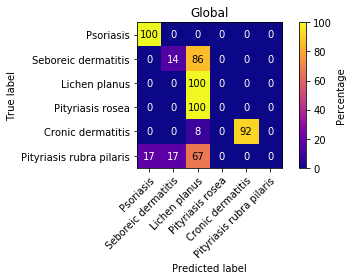

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           6       0.00      0.00      0.00         6

   micro avg       0.00      0.00      0.00         6
   macro avg       0.00      0.00      0.00         6
weighted avg       0.00      0.00      0.00         6

Mean Absolute Error: 0.47
Model Accuracy: 76.67
(array([1, 2, 3, 4, 5, 6]), array([111,  60,  71,  48,  48,  20]))
(array([1, 2, 3, 4, 5, 6]), array([80, 46, 58, 34, 36, 14]))
(array([1, 2, 3, 4, 5, 6]), array([31, 14, 13, 14, 12,  6]))


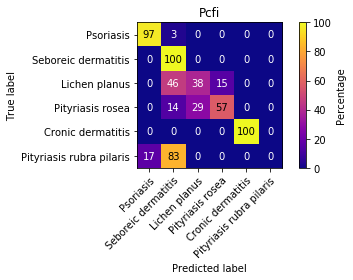

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           6       0.00      0.00      0.00         6

   micro avg       0.00      0.00      0.00         6
   macro avg       0.00      0.00      0.00         6
weighted avg       0.00      0.00      0.00         6

Pityriasis rubra pilaris
Mean Absolute Error: 1.36
Model Accuracy: 43.33
(array([1, 2, 3, 4, 5, 6]), array([111,  60,  71,  48,  48,  20]))
(array([1, 2, 3, 4, 5, 6]), array([80, 46, 58, 34, 36, 14]))
(array([1, 2, 3, 4, 5, 6]), array([31, 14, 13, 14, 12,  6]))


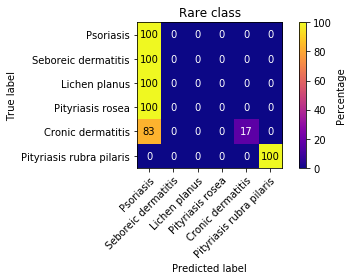

              precision    recall  f1-score   support

           6       1.00      1.00      1.00         6

   micro avg       1.00      1.00      1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [56]:
#Import dermatology data #BOTH POINTS
col_names = np.array([
    'erythema', 'scaling', 'definite borders',
    'itching', 'koebner phenomenon', 'polygonal papules',
    'follicular papules', 'oral mucosal involvement', 'knee and elbow involvement',
    'scalp involvement', 'family history', 'melanin incontinence',
    'eosinophils in the infiltrate', 'PNL infiltrate', 'fibrosis of the papillary dermis',
    'exocytosis', 'acanthosis', 'hyperkeratosis',
    'parakeratosis', 'clubbing of the rete ridges', 'elongation of the rete ridges',
    'thinning of the suprapapillary epidermis', 'spongiform pustule', 'munro microabcess',
    'focal hypergranulosis', 'disappearance of the granular layer',
    'vacuolisation and damage of basal layer',
    'spongiosis', 'saw-tooth appearance of retes', 'follicular horn plug',
    'perifollicular parakeratosis', 'inflammatory monoluclear inflitrate',
    'band-like infiltrate',
    'Age', 'Class'
])
col_names = np.array([lab.capitalize() for lab in col_names])
feature_names = np.array(col_names[:-1])
class_col = col_names[-1]
class_names = np.array(['psoriasis', 'seboreic dermatitis', 'lichen planus',
                        'pityriasis rosea', 'cronic dermatitis', 'pityriasis rubra pilaris'])
class_names = np.array([lab.capitalize() for lab in class_names])
class_tags = np.arange(len(class_names)) + 1
data = pd.read_csv(proj_path+'/0_data/dermatology.data.csv', header=None, names=col_names)
skip_rows = data.Age == '?'
data = data[~skip_rows]
data.Age = np.array(data.Age, dtype=int)

rnd_seed = 45
data_info = ['Dermatology', data, feature_names, class_col, class_names, class_tags, rnd_seed]
datasets.append(data_info)

rf_params = fit_RF(*data_info)
top_features = f_top5(*(rf_params[:3]))
plot_analyses(data_info, top_features, rf_params)

0.5148868827771501
0.9999999999999998


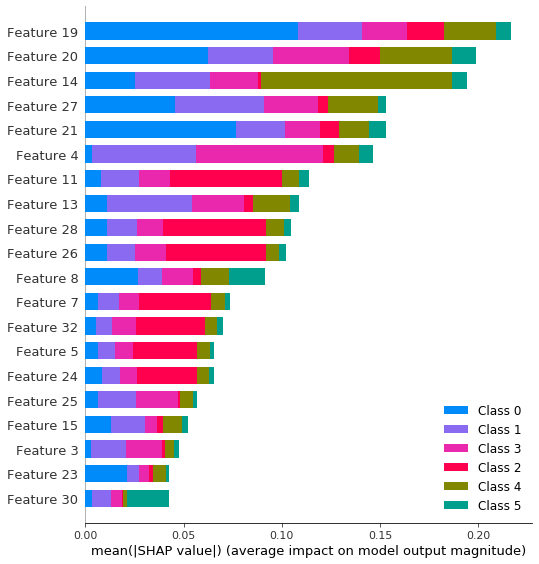

[array(['Clubbing of the rete ridges', 'Fibrosis of the papillary dermis',
       'Elongation of the rete ridges'], dtype='<U40'), array(['Fibrosis of the papillary dermis', 'Clubbing of the rete ridges',
       'Koebner phenomenon'], dtype='<U40'), array(['Perifollicular parakeratosis', 'Follicular horn plug',
       'Follicular papules'], dtype='<U40'), 5, False]
Dermatology False False Pityriasis rubra pilaris False
['Clubbing of the rete ridges' 'Fibrosis of the papillary dermis'
 'Elongation of the rete ridges']
['Fibrosis of the papillary dermis' 'Clubbing of the rete ridges'
 'Koebner phenomenon']
['Perifollicular parakeratosis' 'Follicular horn plug'
 'Follicular papules']
Mean Absolute Error: 0.54
Model Accuracy: 63.33
(array([1, 2, 3, 4, 5, 6]), array([111,  60,  71,  48,  48,  20]))
(array([1, 2, 3, 4, 5, 6]), array([80, 46, 58, 34, 36, 14]))
(array([1, 2, 3, 4, 5, 6]), array([31, 14, 13, 14, 12,  6]))


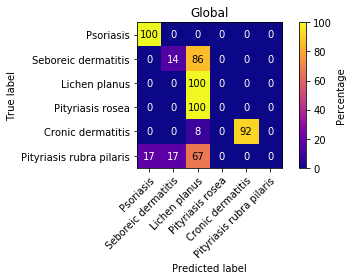

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           6       0.00      0.00      0.00         6

   micro avg       0.00      0.00      0.00         6
   macro avg       0.00      0.00      0.00         6
weighted avg       0.00      0.00      0.00         6

Mean Absolute Error: 0.47
Model Accuracy: 76.67
(array([1, 2, 3, 4, 5, 6]), array([111,  60,  71,  48,  48,  20]))
(array([1, 2, 3, 4, 5, 6]), array([80, 46, 58, 34, 36, 14]))
(array([1, 2, 3, 4, 5, 6]), array([31, 14, 13, 14, 12,  6]))


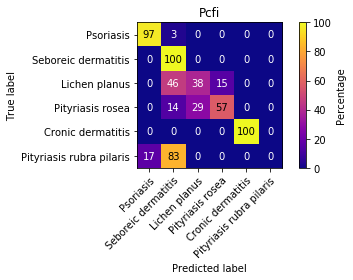

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           6       0.00      0.00      0.00         6

   micro avg       0.00      0.00      0.00         6
   macro avg       0.00      0.00      0.00         6
weighted avg       0.00      0.00      0.00         6

Pityriasis rubra pilaris
Mean Absolute Error: 1.36
Model Accuracy: 43.33
(array([1, 2, 3, 4, 5, 6]), array([111,  60,  71,  48,  48,  20]))
(array([1, 2, 3, 4, 5, 6]), array([80, 46, 58, 34, 36, 14]))
(array([1, 2, 3, 4, 5, 6]), array([31, 14, 13, 14, 12,  6]))


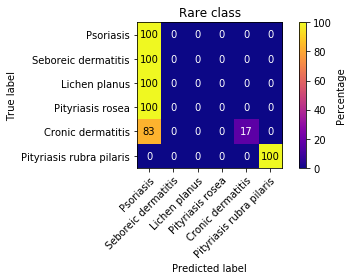

              precision    recall  f1-score   support

           6       1.00      1.00      1.00         6

   micro avg       1.00      1.00      1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [65]:
#fit_RF(label, data, feature_names, class_col, class_names, class_tags, rnd_seed=45):
X = np.array(data.loc[:,feature_names])
y = np.array(data.loc[:,class_col])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rnd_seed)

# train the classifier
rf_clf = RandomForestClassifier(random_state=rnd_seed, n_estimators=100)
rf_clf.fit(X_train, y_train)


rf_clf, feature_names, y, y_test, predictions, class_names = rf_params

explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_train)
shap_imp_mat = np.array([np.mean(abs(class_shap), axis=0) for class_shap in shap_values])
#print(shap_imp_mat)
###NORMALIZE ROWS
print(shap_imp_mat[0].sum())
row_sums = shap_imp_mat.sum(axis=1)
shap_imp_mat = shap_imp_mat / row_sums[:, np.newaxis]
print(shap_imp_mat[0].sum())
###
shap_imp = np.sum(shap_imp_mat, axis=0)

shap.summary_plot(shap_values, X_train)

shap_index = np.argsort(shap_imp)
shap_index = shap_index[::-1]
top_shap = feature_names[shap_index[:3]]
top_features[0] = top_shap
print(top_features)
#rf_params = f_top5(rf_clf, feature_names, y)
plot_analyses(data_info, top_features, rf_params)

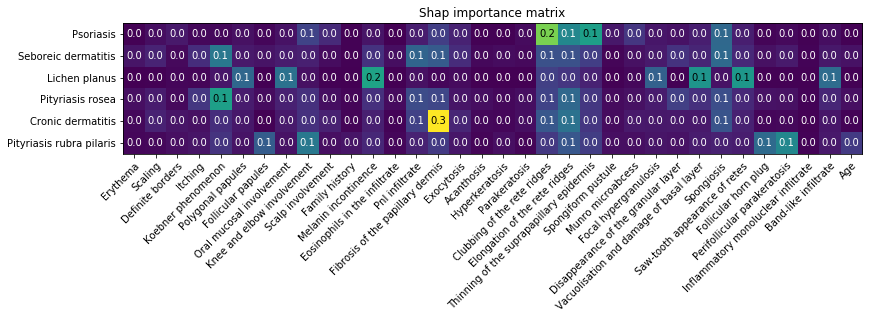

In [66]:
# plot the result
fig, ax = plt.subplots(figsize=(len(feature_names)*0.4, len(class_names)*0.4))
imp_mat = shap_imp_mat
im = ax.imshow(imp_mat)

# adding figure annotations
ax.set_xticks(np.arange(imp_mat.shape[1]))
ax.set_yticks(np.arange(imp_mat.shape[0]))
ax.set_xticklabels(feature_names)
ax.set_yticklabels(class_names)

# rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# create text annotations over the heatmap
thresh = imp_mat.max() / 2.
for i in range(len(class_names)):
    for j in range(len(feature_names)):
        text = ax.text(j, i, round(imp_mat[i, j], 1), ha="center", va="center",
                       color="black" if imp_mat[i, j] > thresh else "white")
        
ax.set_title("Shap importance matrix")
#fig.savefig(fig_path+'/importance_matrix.pdf', bbox_inches='tight')
plt.show()

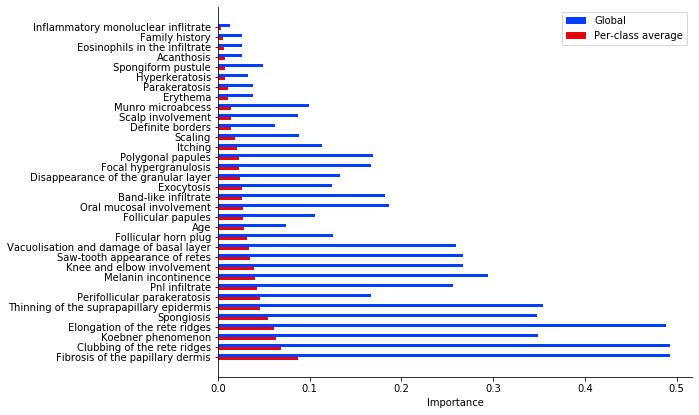

In [61]:
###GLOBAL VS PER-CLASS AVERAGE IMPORTANCE
fig, ax = plt.subplots(figsize=(len(feature_names)/4, len(feature_names)/5))
global_importance = shap_imp#rf_clf.feature_importances_
imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)
mean_importance = np.mean(imp_mat, axis=0)
imp_index = np.argsort(mean_importance)
height = 0.3
y_g = np.arange(len(imp_index))[::-1] + (height / 2.)
y_m = np.arange(len(imp_index))[::-1] - (height / 2.)
ax.barh(y=y_g, width=global_importance[imp_index], height=height,
        color=sns.color_palette('bright')[0], label='Global')
ax.barh(y=y_m, width=mean_importance[imp_index], height=height,
        color=sns.color_palette('bright')[3], label='Per-class average')
ax.set_xlabel('Importance')
ax.set_yticks(np.arange(len(imp_index))[::-1])
ax.set_yticklabels(feature_names[imp_index])
ax.legend(loc=1)#bbox_to_anchor=(1.05, 1.05))
sns.despine(fig=fig)
#fig.savefig(fig_path+'/importance_comparison.pdf', bbox_inches='tight')
plt.show()

Mean Absolute Error: 0.33
Model Accuracy: 69.7
(array([1, 2, 3, 4]), array([27, 54, 42,  8]))
(array([1, 2, 3, 4]), array([22, 41, 29,  6]))
(array([1, 2, 3, 4]), array([ 5, 13, 13,  2]))
Student_finals False True Vg False
['Class x percentage' 'Internal assessment percentage'
 'Class xii percentage' 'Father qualification']
['Class x percentage' 'Internal assessment percentage'
 'Class xii percentage' 'Mother qualification']
['Class x percentage' 'Internal assessment percentage'
 'Class xii percentage' 'Mother qualification']
Mean Absolute Error: 0.48
Model Accuracy: 54.55
(array([1, 2, 3, 4]), array([27, 54, 42,  8]))
(array([1, 2, 3, 4]), array([22, 41, 29,  6]))
(array([1, 2, 3, 4]), array([ 5, 13, 13,  2]))


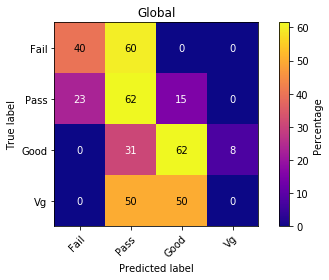

              precision    recall  f1-score   support

           4       0.00      0.00      0.00         2

   micro avg       0.00      0.00      0.00         2
   macro avg       0.00      0.00      0.00         2
weighted avg       0.00      0.00      0.00         2

Mean Absolute Error: 0.36
Model Accuracy: 66.67
(array([1, 2, 3, 4]), array([27, 54, 42,  8]))
(array([1, 2, 3, 4]), array([22, 41, 29,  6]))
(array([1, 2, 3, 4]), array([ 5, 13, 13,  2]))


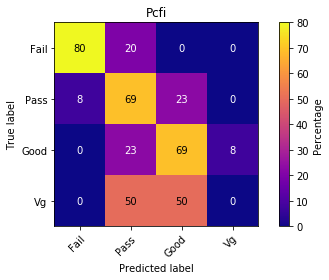

              precision    recall  f1-score   support

           4       0.00      0.00      0.00         2

   micro avg       0.00      0.00      0.00         2
   macro avg       0.00      0.00      0.00         2
weighted avg       0.00      0.00      0.00         2

Vg
Mean Absolute Error: 0.36
Model Accuracy: 66.67
(array([1, 2, 3, 4]), array([27, 54, 42,  8]))
(array([1, 2, 3, 4]), array([22, 41, 29,  6]))
(array([1, 2, 3, 4]), array([ 5, 13, 13,  2]))


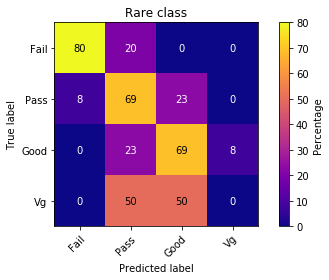

              precision    recall  f1-score   support

           4       0.00      0.00      0.00         2

   micro avg       0.00      0.00      0.00         2
   macro avg       0.00      0.00      0.00         2
weighted avg       0.00      0.00      0.00         2



In [6]:
#Students data #ONLY FEATURE, rare =
col_names = np.array([
    'Gender', 'Caste', 'Class X Percentage', 'Class XII Percentage', 'Internal Assessment Percentage',
    'End Semester Percentage', 'Whether the student has back or arrear papers', 'Marital Status',
    'Lived in Town or Village', 'Admission Category', 'Family Monthly Income', 'Family Size',
    'Father Qualification', 'Mother Qualification', 'Father Occupation', 'Mother Occupation',
    'Number of Friends', 'Study Hours', 'Student School attended at Class X level', 'Medium',
    'Home to College Travel Time', 'Class Attendance Percentage'
])
col_names = np.array([lab.capitalize() for lab in col_names])
students_data = pd.read_csv(proj_path+'/0_data/Student_performances.csv', header=None, names=col_names)
students_data = students_data.loc[:,col_names!='Marital status']

string_to_int_list = [
    {'M':0,'F':1}, {'G':0,'ST':1,'SC':2,'OBC':3,'MOBC':4}, {'Best':4,'Vg':3,'Good':2,'Pass':1,'Fail':0},
    {'Best':4,'Vg':3,'Good':2,'Pass':1,'Fail':0}, {'Best':4,'Vg':3,'Good':2,'Pass':1,'Fail':0},
    {'Best':4,'Vg':3,'Good':2,'Pass':1,'Fail':0}, {'Y':1,'N':0},
    {'T':1,'V':0}, {'Free':0,'Paid':1},
    {'Vh':4,'High':3,'Am':2,'Medium':1,'Low':0}, {'Large':2,'Average':1,'Small':0},
    {'Il':0,'Um':1,'10':2,'12':3,'Degree':4,'Pg':5}, {'Il':0,'Um':1,'10':2,'12':3,'Degree':4,'Pg':5},
    {'Service':0,'Business':1,'Retired':2,'Farmer':3,'Others':4},
    {'Service':0,'Business':1,'Retired':2,'Housewife':3,'Others':4},
    {'Large':2,'Average':1,'Small':0}, {'Good':2,'Average':1,'Poor':0},
    {'Govt':1,'Private':0}, {'Eng':0,'Asm':1,'Hin':2,'Ben':3},
    {'Large':2,'Average':1,'Small':0}, {'Good':2,'Average':1,'Poor':0}
]
for col_name,string_to_int in zip(students_data.columns, string_to_int_list):
    #print(col_name,string_to_int,
    #     students_data.apply(lambda r: string_to_int[r[col_name]], axis=1))
    students_data.loc[:,col_name] = students_data.apply(lambda r: string_to_int[r[col_name]], axis=1)
    
feature_names = np.array(students_data.columns[students_data.columns!='End semester percentage'])
class_col = 'End semester percentage'
class_names = np.array(['Fail', 'Pass', 'Good', 'Vg', 'Best'])
class_tags = np.arange(len(class_names))
#print(feature_names, class_names, class_tags)

#42 definitive
rnd_seed = 44

data_info = ['Student_finals', students_data, feature_names, class_col, class_names, class_tags, rnd_seed]
datasets.append(data_info)
rf_params = fit_RF(*data_info)
top_features = f_top5(*(rf_params[:3]))
plot_analyses(data_info, top_features, rf_params)

Mean Absolute Error: 4.02
Model Accuracy: 54.55
(array([ 1,  2,  5, 11, 12, 14, 18, 22]), array([82, 20, 39, 28, 16, 24, 29, 24]))
(array([ 1,  2,  5, 11, 12, 14, 18, 22]), array([59, 15, 32, 23,  9, 21, 25, 12]))
(array([ 1,  2,  5, 11, 12, 14, 18, 22]), array([23,  5,  7,  5,  7,  3,  4, 12]))
[1, 2, 3, 4, 6, 7, 8, 9, 10, 11]
Tumor False False gallblader False
['Age' 'Sex' 'Lung']
['Age' 'Neck' 'Sex']
['Age' 'Liver' 'Sex']
Mean Absolute Error: 5.67
Model Accuracy: 25.76
(array([ 1,  2,  5, 11, 12, 14, 18, 22]), array([82, 20, 39, 28, 16, 24, 29, 24]))
(array([ 1,  2,  5, 11, 12, 14, 18, 22]), array([59, 15, 32, 23,  9, 21, 25, 12]))
(array([ 1,  2,  5, 11, 12, 14, 18, 22]), array([23,  5,  7,  5,  7,  3,  4, 12]))


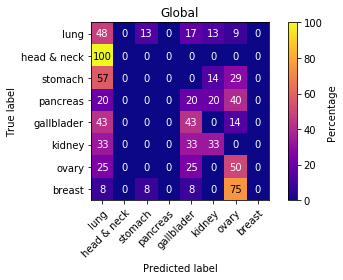

              precision    recall  f1-score   support

          12       0.27      0.43      0.33         7

   micro avg       0.27      0.43      0.33         7
   macro avg       0.27      0.43      0.33         7
weighted avg       0.27      0.43      0.33         7

Mean Absolute Error: 4.83
Model Accuracy: 39.39
(array([ 1,  2,  5, 11, 12, 14, 18, 22]), array([82, 20, 39, 28, 16, 24, 29, 24]))
(array([ 1,  2,  5, 11, 12, 14, 18, 22]), array([59, 15, 32, 23,  9, 21, 25, 12]))
(array([ 1,  2,  5, 11, 12, 14, 18, 22]), array([23,  5,  7,  5,  7,  3,  4, 12]))


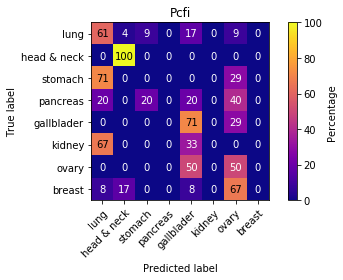

              precision    recall  f1-score   support

          12       0.36      0.71      0.48         7

   micro avg       0.36      0.71      0.48         7
   macro avg       0.36      0.71      0.48         7
weighted avg       0.36      0.71      0.48         7

gallblader
Mean Absolute Error: 5.29
Model Accuracy: 24.24
(array([ 1,  2,  5, 11, 12, 14, 18, 22]), array([82, 20, 39, 28, 16, 24, 29, 24]))
(array([ 1,  2,  5, 11, 12, 14, 18, 22]), array([59, 15, 32, 23,  9, 21, 25, 12]))
(array([ 1,  2,  5, 11, 12, 14, 18, 22]), array([23,  5,  7,  5,  7,  3,  4, 12]))


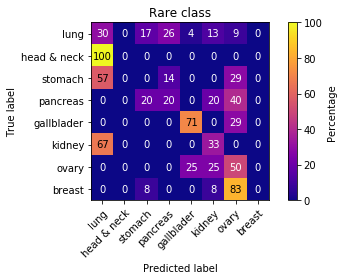

              precision    recall  f1-score   support

          12       0.71      0.71      0.71         7

   micro avg       0.71      0.71      0.71         7
   macro avg       0.71      0.71      0.71         7
weighted avg       0.71      0.71      0.71         7



In [7]:
#Import tumor data #BOTH POINTS -> LOW MODEL ACCURACY!
col_names = np.array([
    'class', 'age', 'sex', 'histologic-type', 'degree-of-diffe', 'bone', 'bone-marrow', 'lung', 'pleura',
    'peritoneum', 'liver', 'brain', 'skin', 'neck', 'supraclavicular', 'axillar', 'mediastinum', 'abdominal'
])
col_names = np.array([lab.capitalize() for lab in col_names])
feature_names = col_names[col_names!='Class']
class_names = np.array([
    'lung', 'head & neck', 'esophasus', 'thyroid', 'stomach', 'duoden & sm.int',
    'colon', 'rectum', 'anus', 'salivary glands', 'pancreas', 'gallblader',
    'liver', 'kidney', 'bladder', 'testis', 'prostate', 'ovary', 'corpus uteri', 
    'cervix uteri', 'vagina', 'breast'
])
#class_tags = np.arange(len(class_names))
tumor_data = pd.read_csv(proj_path+'/0_data/primary-tumor.data.csv', header=None, names=col_names)
tumor_data = tumor_data.loc[:,[col for col in col_names if not(col in ['Histologic-type', 'Degree-of-diffe'])]]
tumor_data.apply(lambda r: any(r=='?'),axis=1)
tumor_data = tumor_data.loc[~(tumor_data.apply(lambda r: any(r=='?'),axis=1)),:]
#print(np.unique(tumor_data.Class, return_counts=True))
class_tags, class_counts = np.unique(tumor_data.Class, return_counts=True)
keep = class_tags[class_counts>=15]

#low_data_classes = np.array([6, 9, 10, 15, 16, 20, 21])

#print('Keep classes', class_names[keep-1])
tumor_data = tumor_data.loc[tumor_data.Class.isin(keep)]

col_names = tumor_data.columns
feature_names = np.array(col_names[col_names!='Class'])
class_names = np.array([col for col in class_names if col in class_names[keep-1]])
class_tags = np.unique(tumor_data.Class)
class_col = 'Class'
#print(class_names, feature_names, np.unique(tumor_data.Class, return_counts=True))
#45
rnd_seed = 45
data_info = ['Tumor', tumor_data, feature_names, class_col, class_names, class_tags, rnd_seed]
datasets.append(data_info)
rf_params = fit_RF(*data_info)
top_features = f_top5(*(rf_params[:3]))
plot_analyses(data_info, top_features, rf_params)


Mean Absolute Error: 0.63
Model Accuracy: 71.43
(array([0, 1, 2, 3, 4, 5]), array([40, 60, 36, 27, 15, 16]))
(array([0, 1, 2, 3, 4, 5]), array([32, 44, 22, 25,  9, 13]))
(array([0, 1, 2, 3, 4, 5]), array([ 8, 16, 14,  2,  6,  3]))
Flag False False Marxist False
['Landmass' 'Language' 'Area' 'Population' 'Zone' 'Stripes']
['Landmass' 'Language' 'Area' 'Population' 'Zone' 'Topleft']
['Population' 'Area' 'Language' 'Landmass' 'Sunstars' 'Zone']
Mean Absolute Error: 0.84
Model Accuracy: 57.14
(array([0, 1, 2, 3, 4, 5]), array([40, 60, 36, 27, 15, 16]))
(array([0, 1, 2, 3, 4, 5]), array([32, 44, 22, 25,  9, 13]))
(array([0, 1, 2, 3, 4, 5]), array([ 8, 16, 14,  2,  6,  3]))


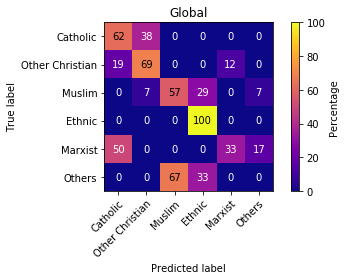

              precision    recall  f1-score   support

           4       0.50      0.33      0.40         6

   micro avg       0.50      0.33      0.40         6
   macro avg       0.50      0.33      0.40         6
weighted avg       0.50      0.33      0.40         6

Mean Absolute Error: 0.73
Model Accuracy: 63.27
(array([0, 1, 2, 3, 4, 5]), array([40, 60, 36, 27, 15, 16]))
(array([0, 1, 2, 3, 4, 5]), array([32, 44, 22, 25,  9, 13]))
(array([0, 1, 2, 3, 4, 5]), array([ 8, 16, 14,  2,  6,  3]))


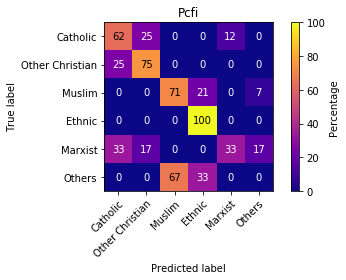

              precision    recall  f1-score   support

           4       0.67      0.33      0.44         6

   micro avg       0.67      0.33      0.44         6
   macro avg       0.67      0.33      0.44         6
weighted avg       0.67      0.33      0.44         6

Marxist
Mean Absolute Error: 0.78
Model Accuracy: 59.18
(array([0, 1, 2, 3, 4, 5]), array([40, 60, 36, 27, 15, 16]))
(array([0, 1, 2, 3, 4, 5]), array([32, 44, 22, 25,  9, 13]))
(array([0, 1, 2, 3, 4, 5]), array([ 8, 16, 14,  2,  6,  3]))


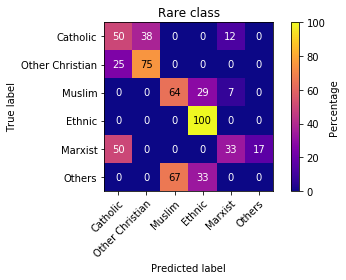

              precision    recall  f1-score   support

           4       0.50      0.33      0.40         6

   micro avg       0.50      0.33      0.40         6
   macro avg       0.50      0.33      0.40         6
weighted avg       0.50      0.33      0.40         6



In [8]:
#Import flag data #BOTH POINTS
col_names = np.array([
    'name', 'landmass', 'zone', 'area', 'population', 'language', 'religion', 'bars', 'stripes', 'colours',
    'red', 'green', 'blue', 'gold', 'white', 'black', 'orange', 'mainhue', 'circles', 'crosses', 'saltires',
    'quarters', 'sunstars', 'crescent', 'triangle', 'icon', 'animate', 'text', 'topleft', 'botright'
])
col_names = np.array([lab.capitalize() for lab in col_names])

feature_names = np.array(col_names[np.logical_and(col_names!='Religion', col_names!='Name')])
class_col = 'Religion'
class_names = np.array(['Catholic', 'Other Christian', 'Muslim',# 'Buddhist', 'Hindu',
                        'Ethnic', 'Marxist', 'Others'])

class_tags = np.arange(len(class_names))
flag_data = pd.read_csv(proj_path+'/0_data/flag.data.csv', header=None, names=col_names)

string_to_int = {'black':0, 'blue':1, 'brown':2, 'gold':3, 'green':4, 'orange':5, 'red':6, 'white':7}
for col_name in ['Mainhue', 'Topleft', 'Botright']:
    #print(col_name,string_to_int)
    flag_data.loc[:,col_name] = flag_data.apply(lambda r: string_to_int[r[col_name]], axis=1)
string_to_int = {0:0, 1:1, 2:2, 3:5, 4:5, 5:3, 6:4, 7:5}
flag_data.loc[:,['Religion']] = flag_data.apply(lambda r: string_to_int[r['Religion']], axis=1)

#45 (lower than 70 accuracy)
rnd_seed = 44

data_info = ['Flag', flag_data, feature_names, class_col, class_names, class_tags, rnd_seed]
datasets.append(data_info)
rf_params = fit_RF(*data_info)
top_features = f_top5(*(rf_params[:3]))
plot_analyses(data_info, top_features, rf_params)

Mean Absolute Error: 0.59
Model Accuracy: 74.07
(array([0, 1, 2, 3, 4, 5]), array([22, 21, 14, 15, 16, 18]))
(array([0, 1, 2, 3, 4, 5]), array([18, 15, 11, 10, 13, 12]))
(array([0, 1, 2, 3, 4, 5]), array([4, 6, 3, 5, 3, 6]))
FAIL
Breast_tissue True False con False
['I0' 'P' 'Max IP']
['I0' 'P' 'Max IP']
['I0' 'P' 'DA']
Mean Absolute Error: 0.48
Model Accuracy: 66.67
(array([0, 1, 2, 3, 4, 5]), array([22, 21, 14, 15, 16, 18]))
(array([0, 1, 2, 3, 4, 5]), array([18, 15, 11, 10, 13, 12]))
(array([0, 1, 2, 3, 4, 5]), array([4, 6, 3, 5, 3, 6]))


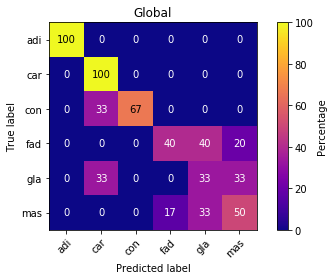

              precision    recall  f1-score   support

           2       1.00      0.67      0.80         3

   micro avg       1.00      0.67      0.80         3
   macro avg       1.00      0.67      0.80         3
weighted avg       1.00      0.67      0.80         3

Mean Absolute Error: 0.48
Model Accuracy: 66.67
(array([0, 1, 2, 3, 4, 5]), array([22, 21, 14, 15, 16, 18]))
(array([0, 1, 2, 3, 4, 5]), array([18, 15, 11, 10, 13, 12]))
(array([0, 1, 2, 3, 4, 5]), array([4, 6, 3, 5, 3, 6]))


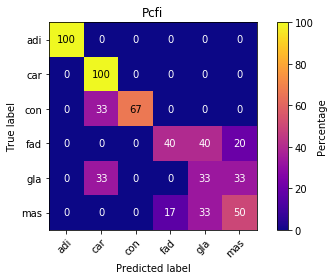

              precision    recall  f1-score   support

           2       1.00      0.67      0.80         3

   micro avg       1.00      0.67      0.80         3
   macro avg       1.00      0.67      0.80         3
weighted avg       1.00      0.67      0.80         3

con
Mean Absolute Error: 0.93
Model Accuracy: 55.56
(array([0, 1, 2, 3, 4, 5]), array([22, 21, 14, 15, 16, 18]))
(array([0, 1, 2, 3, 4, 5]), array([18, 15, 11, 10, 13, 12]))
(array([0, 1, 2, 3, 4, 5]), array([4, 6, 3, 5, 3, 6]))


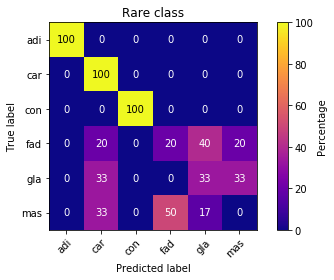

              precision    recall  f1-score   support

           2       1.00      1.00      1.00         3

   micro avg       1.00      1.00      1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



In [9]:
#Breast tissue data #= AND RARE CLASS #JUSTIFY 46

breast_data = pd.read_excel(proj_path+'/0_data/BreastTissue.xls', sheet_name=1)
breast_data = breast_data.iloc[:,1:]

feature_names = np.array(breast_data.columns[1:])
class_col = 'Class'
class_names = np.unique(breast_data.Class)
class_tags = np.arange(len(class_names))

string_to_int = dict(zip(class_names, class_tags))
breast_data.loc[:,'Class'] = breast_data.apply(lambda r: string_to_int[r.Class], axis=1)

rnd_seed = 46

data_info = ['Breast_tissue', breast_data, feature_names, class_col, class_names, class_tags, rnd_seed]
datasets.append(data_info)
rf_params = fit_RF(*data_info)
top_features = f_top5(*(rf_params[:3]))
plot_analyses(data_info, top_features, rf_params)

['Buying' 'Maint' 'Doors' 'Persons' 'Lug_boot' 'Safety'] ['unacc' 'acc' 'good' 'vgood'] [0 1 2 3]
Mean Absolute Error: 0.03
Model Accuracy: 98.15
(array([0, 1, 2, 3]), array([1210,  384,   69,   65]))
(array([0, 1, 2, 3]), array([908, 288,  51,  49]))
(array([0, 1, 2, 3]), array([302,  96,  18,  16]))
FAIL
Cars True False vgood False
['Safety' 'Persons' 'Maint']
['Safety' 'Persons' 'Maint']
['Safety' 'Buying' 'Lug_boot']
Mean Absolute Error: 0.27
Model Accuracy: 76.62
(array([0, 1, 2, 3]), array([1210,  384,   69,   65]))
(array([0, 1, 2, 3]), array([908, 288,  51,  49]))
(array([0, 1, 2, 3]), array([302,  96,  18,  16]))


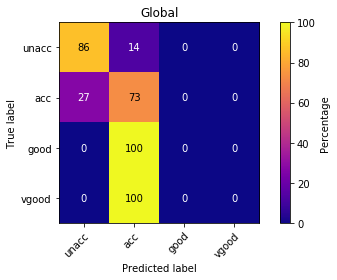

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           3       0.00      0.00      0.00        16

   micro avg       0.00      0.00      0.00        16
   macro avg       0.00      0.00      0.00        16
weighted avg       0.00      0.00      0.00        16

Mean Absolute Error: 0.27
Model Accuracy: 76.62
(array([0, 1, 2, 3]), array([1210,  384,   69,   65]))
(array([0, 1, 2, 3]), array([908, 288,  51,  49]))
(array([0, 1, 2, 3]), array([302,  96,  18,  16]))


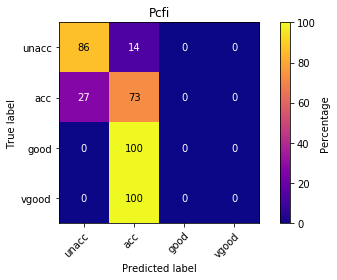

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           3       0.00      0.00      0.00        16

   micro avg       0.00      0.00      0.00        16
   macro avg       0.00      0.00      0.00        16
weighted avg       0.00      0.00      0.00        16

vgood
Mean Absolute Error: 0.4
Model Accuracy: 67.82
(array([0, 1, 2, 3]), array([1210,  384,   69,   65]))
(array([0, 1, 2, 3]), array([908, 288,  51,  49]))
(array([0, 1, 2, 3]), array([302,  96,  18,  16]))


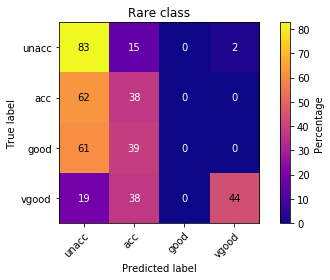

              precision    recall  f1-score   support

           3       0.54      0.44      0.48        16

   micro avg       0.54      0.44      0.48        16
   macro avg       0.54      0.44      0.48        16
weighted avg       0.54      0.44      0.48        16



In [10]:
#Car data # = , rare PONIT

col_names = np.array([
    'buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'
])
col_names = np.array([lab.capitalize() for lab in col_names])
car_data = pd.read_csv(proj_path+'/0_data/car.data.csv', header=None, names=col_names)

string_to_int_list = [
    {'vhigh':3, 'high':2, 'med':1, 'low':0},
    {'vhigh':3, 'high':2, 'med':1, 'low':0},
    {'2':2, '3':3, '4':4, '5more':5},
    {'2':0, '4':1, 'more':2},
    {'small':0, 'med':1, 'big':2},
    {'low':0, 'med':1, 'high':2},
    {'unacc':0, 'acc':1, 'good':2, 'vgood':3}
]

for col_name,string_to_int in zip(car_data.columns, string_to_int_list):
    car_data.loc[:,col_name] = car_data.apply(lambda r: string_to_int[r[col_name]], axis=1)

    
feature_names = np.array(car_data.columns[car_data.columns!='Class'])
class_col = 'Class'
class_names = np.array(['unacc', 'acc', 'good', 'vgood'])
class_tags = np.arange(len(class_names))
print(feature_names, class_names, class_tags)

rnd_seed = 45
data_info = ['Cars', car_data, feature_names, class_col, class_names, class_tags, rnd_seed]
datasets.append(data_info)
rf_params = fit_RF(*data_info)
top_features = f_top5(*(rf_params[:3]))
plot_analyses(data_info, top_features, rf_params)

Mean Absolute Error: 0.04
Model Accuracy: 98.2
(array([1, 2, 3, 4]), array([500, 500, 500, 500]))
(array([1, 2, 3, 4]), array([372, 379, 378, 371]))
(array([1, 2, 3, 4]), array([128, 121, 122, 129]))
FAIL
Wifi True True 1 True
['Signal 1' 'Signal 5' 'Signal 4']
['Signal 1' 'Signal 5' 'Signal 4']
['Signal 1' 'Signal 5' 'Signal 4']
Mean Absolute Error: 0.04
Model Accuracy: 97.8
(array([1, 2, 3, 4]), array([500, 500, 500, 500]))
(array([1, 2, 3, 4]), array([372, 379, 378, 371]))
(array([1, 2, 3, 4]), array([128, 121, 122, 129]))


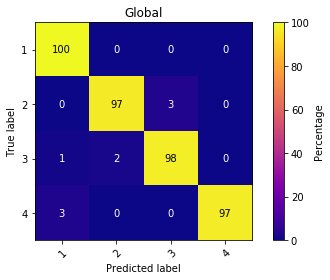

              precision    recall  f1-score   support

           1       0.96      1.00      0.98       128

   micro avg       0.96      1.00      0.98       128
   macro avg       0.96      1.00      0.98       128
weighted avg       0.96      1.00      0.98       128

Mean Absolute Error: 0.04
Model Accuracy: 97.8
(array([1, 2, 3, 4]), array([500, 500, 500, 500]))
(array([1, 2, 3, 4]), array([372, 379, 378, 371]))
(array([1, 2, 3, 4]), array([128, 121, 122, 129]))


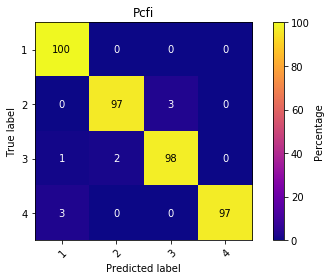

              precision    recall  f1-score   support

           1       0.96      1.00      0.98       128

   micro avg       0.96      1.00      0.98       128
   macro avg       0.96      1.00      0.98       128
weighted avg       0.96      1.00      0.98       128

1
Mean Absolute Error: 0.04
Model Accuracy: 97.8
(array([1, 2, 3, 4]), array([500, 500, 500, 500]))
(array([1, 2, 3, 4]), array([372, 379, 378, 371]))
(array([1, 2, 3, 4]), array([128, 121, 122, 129]))


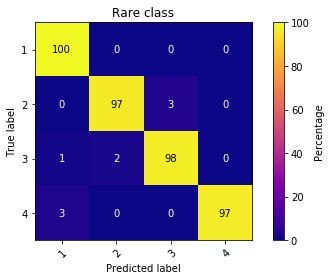

              precision    recall  f1-score   support

           1       0.96      1.00      0.98       128

   micro avg       0.96      1.00      0.98       128
   macro avg       0.96      1.00      0.98       128
weighted avg       0.96      1.00      0.98       128



In [11]:
#WiFi signals data #BOTH = BY BLANACED
wifi_data = pd.read_excel(proj_path+'/0_data/WiFi_signals.xls')

class_names = np.unique(wifi_data.Room)
feature_names = np.array(wifi_data.columns[wifi_data.columns!='Room'])
class_col = 'Room'
class_tags = class_names
#print(class_names, feature_names, np.unique(wifi_data.Room, return_counts=True))

rnd_seed = 45

data_info = ['Wifi', wifi_data, feature_names, class_col, class_names, class_tags, rnd_seed]
datasets.append(data_info)
rf_params = fit_RF(*data_info)
top_features = f_top5(*(rf_params[:3]))
plot_analyses(data_info, top_features, rf_params)

Mean Absolute Error: 0.05
Model Accuracy: 94.74
(array([0, 1, 2]), array([50, 50, 50]))
(array([0, 1, 2]), array([36, 41, 35]))
(array([0, 1, 2]), array([14,  9, 15]))
FAIL
Iris True True setosa True
['petal width (cm)' 'petal length (cm)' 'sepal length (cm)']
['petal width (cm)' 'petal length (cm)' 'sepal length (cm)']
['petal width (cm)' 'petal length (cm)' 'sepal length (cm)']
Mean Absolute Error: 0.05
Model Accuracy: 94.74
(array([0, 1, 2]), array([50, 50, 50]))
(array([0, 1, 2]), array([36, 41, 35]))
(array([0, 1, 2]), array([14,  9, 15]))


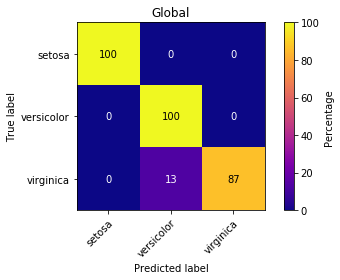

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14

   micro avg       1.00      1.00      1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

Mean Absolute Error: 0.05
Model Accuracy: 94.74
(array([0, 1, 2]), array([50, 50, 50]))
(array([0, 1, 2]), array([36, 41, 35]))
(array([0, 1, 2]), array([14,  9, 15]))


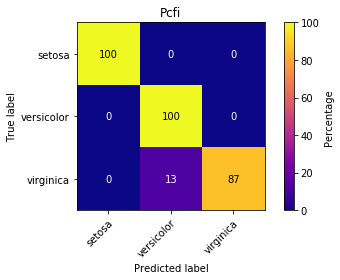

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14

   micro avg       1.00      1.00      1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

setosa
Mean Absolute Error: 0.05
Model Accuracy: 94.74
(array([0, 1, 2]), array([50, 50, 50]))
(array([0, 1, 2]), array([36, 41, 35]))
(array([0, 1, 2]), array([14,  9, 15]))


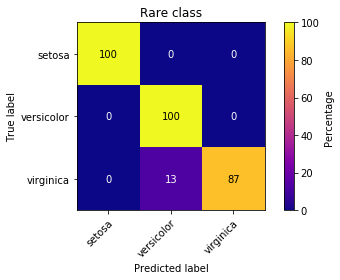

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14

   micro avg       1.00      1.00      1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



In [12]:
#Import iris #ALL = BALANCED
from sklearn.datasets import load_iris

iris = load_iris()
feature_names = np.array(iris.feature_names)
class_names = iris.target_names
class_tags = np.array([0, 1, 2])
class_col = 'Class'

iris_data = pd.DataFrame(iris.data,columns=feature_names)
iris_data[class_col] = pd.Series(iris.target)

rnd_seed = 45
data_info = ['Iris', iris_data, feature_names, class_col, class_names, class_tags, rnd_seed]
datasets.append(data_info)
rf_params = fit_RF(*data_info)
top_features = f_top5(*(rf_params[:3]))
plot_analyses(data_info, top_features, rf_params)

Mean Absolute Error: 0.0
Model Accuracy: 100.0
(array([0, 1, 2]), array([59, 71, 48]))
(array([0, 1, 2]), array([47, 54, 32]))
(array([0, 1, 2]), array([12, 17, 16]))
Wine False False class_2 False
['flavanoids' 'color_intensity' 'proline' 'alcohol'
 'od280/od315_of_diluted_wines' 'hue' 'magnesium']
['flavanoids' 'color_intensity' 'proline' 'alcohol'
 'od280/od315_of_diluted_wines' 'hue' 'malic_acid']
['flavanoids' 'od280/od315_of_diluted_wines' 'color_intensity' 'hue'
 'proanthocyanins' 'proline' 'malic_acid']
Mean Absolute Error: 0.0
Model Accuracy: 100.0
(array([0, 1, 2]), array([59, 71, 48]))
(array([0, 1, 2]), array([47, 54, 32]))
(array([0, 1, 2]), array([12, 17, 16]))


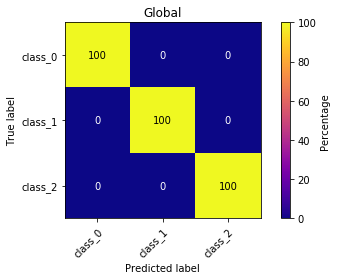

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        16

   micro avg       1.00      1.00      1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

Mean Absolute Error: 0.0
Model Accuracy: 100.0
(array([0, 1, 2]), array([59, 71, 48]))
(array([0, 1, 2]), array([47, 54, 32]))
(array([0, 1, 2]), array([12, 17, 16]))


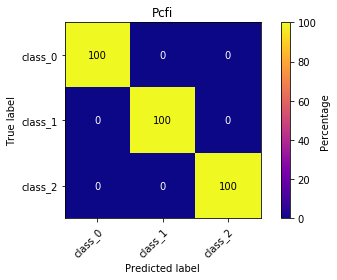

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        16

   micro avg       1.00      1.00      1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

class_2
Mean Absolute Error: 0.04
Model Accuracy: 95.56
(array([0, 1, 2]), array([59, 71, 48]))
(array([0, 1, 2]), array([47, 54, 32]))
(array([0, 1, 2]), array([12, 17, 16]))


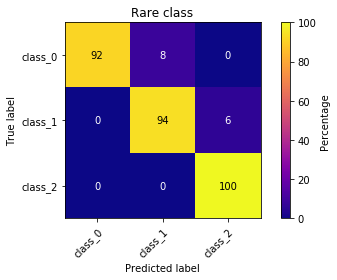

              precision    recall  f1-score   support

           2       0.94      1.00      0.97        16

   micro avg       0.94      1.00      0.97        16
   macro avg       0.94      1.00      0.97        16
weighted avg       0.94      1.00      0.97        16



In [14]:
#Import wine #= + rare loss -> BEWARE OF FALSE POSITIVE
from sklearn.datasets import load_wine

wines = load_wine()
feature_names = np.array(wines.feature_names)
class_names = wines.target_names
class_tags = np.array([0, 1, 2])
class_col = 'Class'

wine_data = pd.DataFrame(wines.data,columns=feature_names)
wine_data[class_col] = pd.Series(wines.target)

rnd_seed = 45
data_info = ['Wine', wine_data, feature_names, class_col, class_names, class_tags, rnd_seed]
datasets.append(data_info)
rf_params = fit_RF(*data_info)
top_features = f_top5(*(rf_params[:3]))
plot_analyses(data_info, top_features, rf_params)


In [7]:
#Cars data
"""
mtcars_data = pd.read_csv(proj_path+'/0_data/mtcars.csv')
mtcars_data = mtcars_data.iloc[:,1:]

class_names = np.unique(mtcars_data.gear)
feature_names = np.array(mtcars_data.columns[mtcars_data.columns!='gear'])
class_col = 'gear'
class_tags = class_names

rnd_seed = 45
datasets.append(['Mtcars', mtcars_data, feature_names, class_col, class_names, class_tags, rnd_seed])
#fit_RF(*datasets[-1])
"""

"\nmtcars_data = pd.read_csv(proj_path+'/0_data/mtcars.csv')\nmtcars_data = mtcars_data.iloc[:,1:]\n\nclass_names = np.unique(mtcars_data.gear)\nfeature_names = np.array(mtcars_data.columns[mtcars_data.columns!='gear'])\nclass_col = 'gear'\nclass_tags = class_names\n\nrnd_seed = 45\ndatasets.append(['Mtcars', mtcars_data, feature_names, class_col, class_names, class_tags, rnd_seed])\n#fit_RF(*datasets[-1])\n"

In [11]:
#Wholesale customers data
"""
sales_data = pd.read_csv(proj_path+'/0_data/Wholesale customers data.csv')

class_names = np.unique(sales_data.Region)
feature_names = np.array(sales_data.columns[sales_data.columns!='Region'])
class_col = 'Region'
class_tags = class_names
#print(np.unique(sales_data.Region, return_counts=True))
sales_data

rnd_seed = 41
data_info = ['Sales', sales_data, feature_names, class_col, class_names, class_tags, rnd_seed]
datasets.append(data_info)
rf_params = fit_RF(*data_info)
top_features = f_top5(*(rf_params[:3]))
plot_analyses(data_info, top_features, rf_params)
"""

"\nsales_data = pd.read_csv(proj_path+'/0_data/Wholesale customers data.csv')\n\nclass_names = np.unique(sales_data.Region)\nfeature_names = np.array(sales_data.columns[sales_data.columns!='Region'])\nclass_col = 'Region'\nclass_tags = class_names\n#print(np.unique(sales_data.Region, return_counts=True))\nsales_data\n\nrnd_seed = 41\ndata_info = ['Sales', sales_data, feature_names, class_col, class_names, class_tags, rnd_seed]\ndatasets.append(data_info)\nrf_params = fit_RF(*data_info)\ntop_features = f_top5(*(rf_params[:3]))\nplot_analyses(data_info, top_features, rf_params)\n"

Mean Absolute Error: 0.59
Model Accuracy: 71.43
(array([1, 2, 3, 4, 5, 6]), array([31, 17, 35, 52, 39, 20]))
(array([1, 2, 3, 4, 5, 6]), array([24, 13, 26, 37, 32, 13]))
(array([1, 2, 3, 4, 5, 6]), array([ 7,  4,  9, 15,  7,  7]))
[0, 1, 7, 8, 9, 10, 12, 13, 18, 19, 20, 21, 22, 23]
Flag True False S.America False
['Language' 'Zone' 'Religion']
['Language' 'Zone' 'Religion']
['Area' 'Zone' 'Religion']
Mean Absolute Error: 0.63
Model Accuracy: 69.39
(array([1, 2, 3, 4, 5, 6]), array([31, 17, 35, 52, 39, 20]))
(array([1, 2, 3, 4, 5, 6]), array([24, 13, 26, 37, 32, 13]))
(array([1, 2, 3, 4, 5, 6]), array([ 7,  4,  9, 15,  7,  7]))


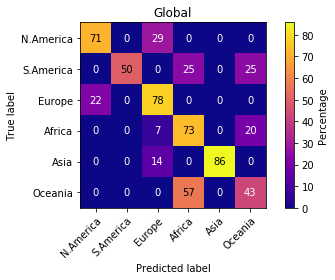

Mean Absolute Error: 0.63
Model Accuracy: 69.39
(array([1, 2, 3, 4, 5, 6]), array([31, 17, 35, 52, 39, 20]))
(array([1, 2, 3, 4, 5, 6]), array([24, 13, 26, 37, 32, 13]))
(array([1, 2, 3, 4, 5, 6]), array([ 7,  4,  9, 15,  7,  7]))


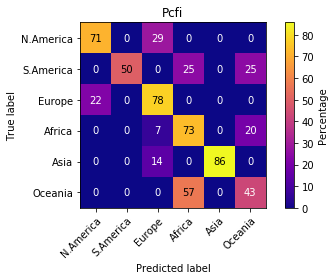

S.America
Mean Absolute Error: 0.55
Model Accuracy: 71.43
(array([1, 2, 3, 4, 5, 6]), array([31, 17, 35, 52, 39, 20]))
(array([1, 2, 3, 4, 5, 6]), array([24, 13, 26, 37, 32, 13]))
(array([1, 2, 3, 4, 5, 6]), array([ 7,  4,  9, 15,  7,  7]))


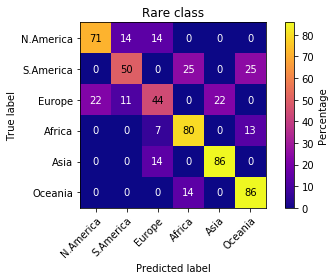

In [7]:
###NO BUONO!

#Import flag data #BOTH = BY UNBLANACEDNESS
col_names = np.array([
    'name', 'landmass', 'zone', 'area', 'population', 'language', 'religion', 'bars', 'stripes', 'colours',
    'red', 'green', 'blue', 'gold', 'white', 'black', 'orange', 'mainhue', 'circles', 'crosses', 'saltires',
    'quarters', 'sunstars', 'crescent', 'triangle', 'icon', 'animate', 'text', 'topleft', 'botright'
])
col_names = np.array([lab.capitalize() for lab in col_names])

#feature_names = np.array(col_names[np.logical_and(col_names!='Religion', col_names!='Name')])
#class_col = 'Religion'
#class_names = np.array(['Catholic', 'Other Christian', 'Muslim', 'Buddhist', 'Hindu', 'Ethnic', 'Marxist', 'Others'])

#1=N.America, 2=S.America, 3=Europe, 4=Africa, 4=Asia, 6=Oceania
feature_names = np.array(col_names[np.logical_and(col_names!='Landmass', col_names!='Name')])
class_col = 'Landmass'
class_names = np.array(['N.America', 'S.America', 'Europe', 'Africa', 'Asia', 'Oceania'])
class_tags = np.arange(len(class_names))
flag_data = pd.read_csv(proj_path+'/0_data/flag.data.csv', header=None, names=col_names)

#print(class_names, feature_names, np.unique(flag_data.Religion, return_counts=True))

string_to_int = {'black':0, 'blue':1, 'brown':2, 'gold':3, 'green':4, 'orange':5, 'red':6, 'white':7}
for col_name in ['Mainhue', 'Topleft', 'Botright']:
    #print(col_name,string_to_int)
    flag_data.loc[:,col_name] = flag_data.apply(lambda r: string_to_int[r[col_name]], axis=1)

#print(flag_data.head())
#print(np.unique(np.hstack([flag_data.Mainhue, flag_data.Topleft, flag_data.Botright])))
rnd_seed = 42

data_info = ['Flag', flag_data, feature_names, class_col, class_names, class_tags, rnd_seed]
datasets.append(data_info)
rf_params = fit_RF(*data_info)
top_features = f_top5(*(rf_params[:3]))
plot_analyses(data_info, top_features, rf_params)

Dermatology False False Pityriasis rubra pilaris False
Mean Absolute Error: 0.54
Model Accuracy: 63.33
(array([1, 2, 3, 4, 5, 6]), array([111,  60,  71,  48,  48,  20]))
(array([1, 2, 3, 4, 5, 6]), array([80, 46, 58, 34, 36, 14]))
(array([1, 2, 3, 4, 5, 6]), array([31, 14, 13, 14, 12,  6]))


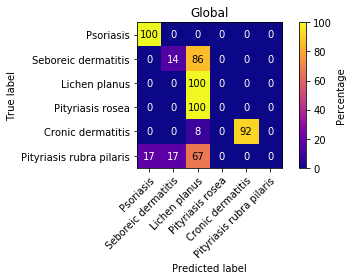

Mean Absolute Error: 0.47
Model Accuracy: 76.67
(array([1, 2, 3, 4, 5, 6]), array([111,  60,  71,  48,  48,  20]))
(array([1, 2, 3, 4, 5, 6]), array([80, 46, 58, 34, 36, 14]))
(array([1, 2, 3, 4, 5, 6]), array([31, 14, 13, 14, 12,  6]))


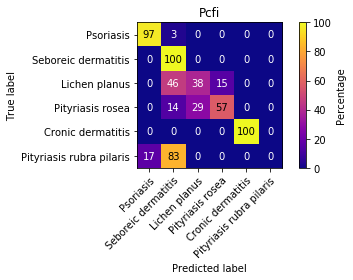

Pityriasis rubra pilaris
Mean Absolute Error: 1.36
Model Accuracy: 43.33
(array([1, 2, 3, 4, 5, 6]), array([111,  60,  71,  48,  48,  20]))
(array([1, 2, 3, 4, 5, 6]), array([80, 46, 58, 34, 36, 14]))
(array([1, 2, 3, 4, 5, 6]), array([31, 14, 13, 14, 12,  6]))


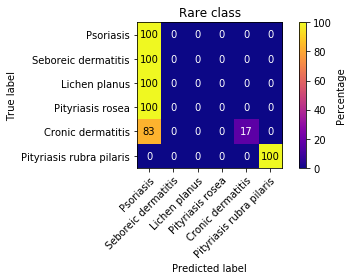

Iris True True setosa True
Mean Absolute Error: 0.05
Model Accuracy: 94.74
(array([0, 1, 2]), array([50, 50, 50]))
(array([0, 1, 2]), array([36, 41, 35]))
(array([0, 1, 2]), array([14,  9, 15]))


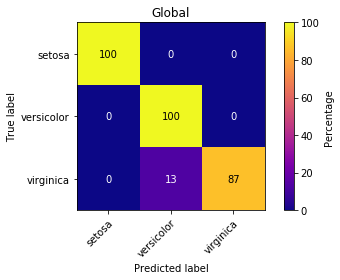

Mean Absolute Error: 0.05
Model Accuracy: 94.74
(array([0, 1, 2]), array([50, 50, 50]))
(array([0, 1, 2]), array([36, 41, 35]))
(array([0, 1, 2]), array([14,  9, 15]))


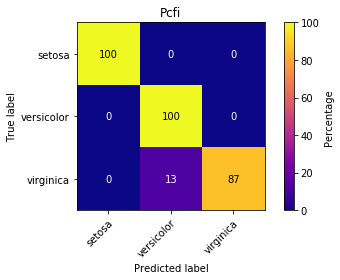

setosa
Mean Absolute Error: 0.05
Model Accuracy: 94.74
(array([0, 1, 2]), array([50, 50, 50]))
(array([0, 1, 2]), array([36, 41, 35]))
(array([0, 1, 2]), array([14,  9, 15]))


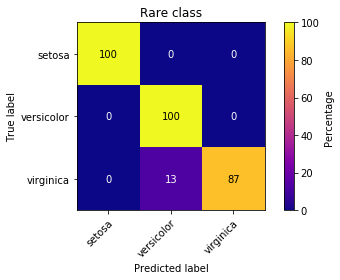

Wine False False class_2 False
Mean Absolute Error: 0.0
Model Accuracy: 100.0
(array([0, 1, 2]), array([59, 71, 48]))
(array([0, 1, 2]), array([47, 54, 32]))
(array([0, 1, 2]), array([12, 17, 16]))


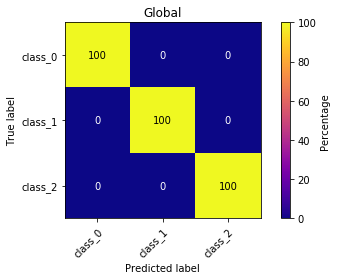

Mean Absolute Error: 0.0
Model Accuracy: 100.0
(array([0, 1, 2]), array([59, 71, 48]))
(array([0, 1, 2]), array([47, 54, 32]))
(array([0, 1, 2]), array([12, 17, 16]))


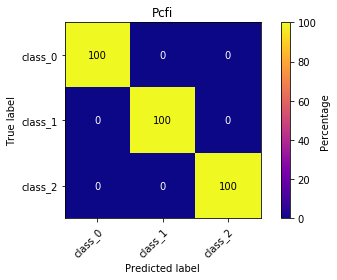

class_2
Mean Absolute Error: 0.04
Model Accuracy: 95.56
(array([0, 1, 2]), array([59, 71, 48]))
(array([0, 1, 2]), array([47, 54, 32]))
(array([0, 1, 2]), array([12, 17, 16]))


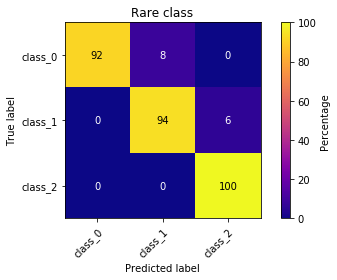

Breast_tissue True False con False
Mean Absolute Error: 0.44
Model Accuracy: 66.67
(array([0, 1, 2, 3, 4, 5]), array([22, 21, 14, 15, 16, 18]))
(array([0, 1, 2, 3, 4, 5]), array([17, 14, 11, 11, 12, 14]))
(array([0, 1, 2, 3, 4, 5]), array([5, 7, 3, 4, 4, 4]))


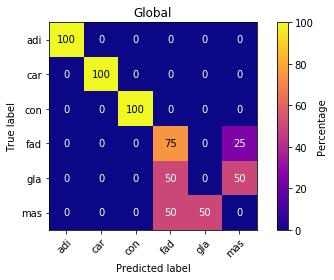

Mean Absolute Error: 0.56
Model Accuracy: 62.96
(array([0, 1, 2, 3, 4, 5]), array([22, 21, 14, 15, 16, 18]))
(array([0, 1, 2, 3, 4, 5]), array([17, 14, 11, 11, 12, 14]))
(array([0, 1, 2, 3, 4, 5]), array([5, 7, 3, 4, 4, 4]))


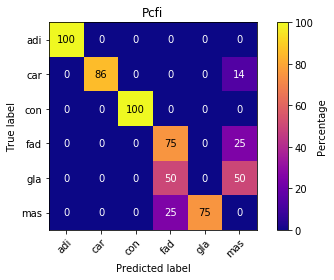

con
Mean Absolute Error: 0.56
Model Accuracy: 74.07
(array([0, 1, 2, 3, 4, 5]), array([22, 21, 14, 15, 16, 18]))
(array([0, 1, 2, 3, 4, 5]), array([17, 14, 11, 11, 12, 14]))
(array([0, 1, 2, 3, 4, 5]), array([5, 7, 3, 4, 4, 4]))


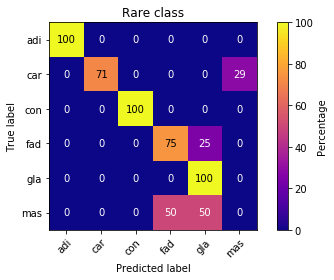

Student_finals False True Vg False
Mean Absolute Error: 0.48
Model Accuracy: 54.55
(array([1, 2, 3, 4]), array([27, 54, 42,  8]))
(array([1, 2, 3, 4]), array([22, 41, 29,  6]))
(array([1, 2, 3, 4]), array([ 5, 13, 13,  2]))


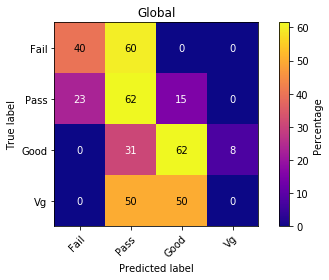

Mean Absolute Error: 0.36
Model Accuracy: 66.67
(array([1, 2, 3, 4]), array([27, 54, 42,  8]))
(array([1, 2, 3, 4]), array([22, 41, 29,  6]))
(array([1, 2, 3, 4]), array([ 5, 13, 13,  2]))


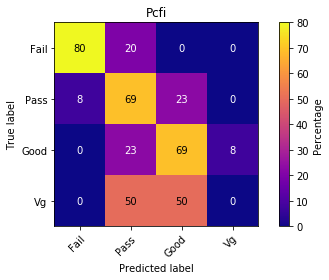

Vg
Mean Absolute Error: 0.36
Model Accuracy: 66.67
(array([1, 2, 3, 4]), array([27, 54, 42,  8]))
(array([1, 2, 3, 4]), array([22, 41, 29,  6]))
(array([1, 2, 3, 4]), array([ 5, 13, 13,  2]))


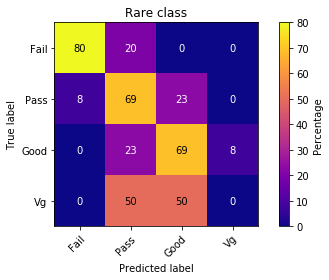

Sales True False 2 False
Mean Absolute Error: 0.57
Model Accuracy: 65.45
(array([1, 2, 3]), array([ 77,  47, 316]))
(array([1, 2, 3]), array([ 57,  38, 235]))
(array([1, 2, 3]), array([20,  9, 81]))


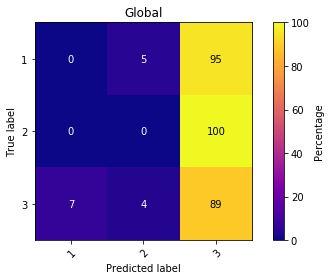

Mean Absolute Error: 0.57
Model Accuracy: 65.45
(array([1, 2, 3]), array([ 77,  47, 316]))
(array([1, 2, 3]), array([ 57,  38, 235]))
(array([1, 2, 3]), array([20,  9, 81]))


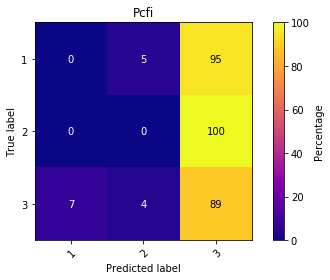

2
Mean Absolute Error: 0.53
Model Accuracy: 69.09
(array([1, 2, 3]), array([ 77,  47, 316]))
(array([1, 2, 3]), array([ 57,  38, 235]))
(array([1, 2, 3]), array([20,  9, 81]))


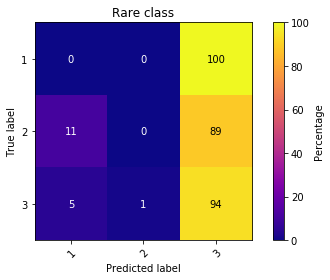

Wifi True True 1 True
Mean Absolute Error: 0.04
Model Accuracy: 97.8
(array([1, 2, 3, 4]), array([500, 500, 500, 500]))
(array([1, 2, 3, 4]), array([372, 379, 378, 371]))
(array([1, 2, 3, 4]), array([128, 121, 122, 129]))


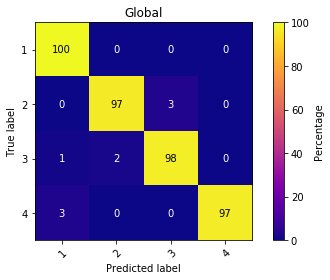

Mean Absolute Error: 0.04
Model Accuracy: 97.8
(array([1, 2, 3, 4]), array([500, 500, 500, 500]))
(array([1, 2, 3, 4]), array([372, 379, 378, 371]))
(array([1, 2, 3, 4]), array([128, 121, 122, 129]))


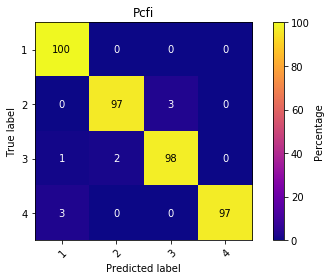

1
Mean Absolute Error: 0.04
Model Accuracy: 97.8
(array([1, 2, 3, 4]), array([500, 500, 500, 500]))
(array([1, 2, 3, 4]), array([372, 379, 378, 371]))
(array([1, 2, 3, 4]), array([128, 121, 122, 129]))


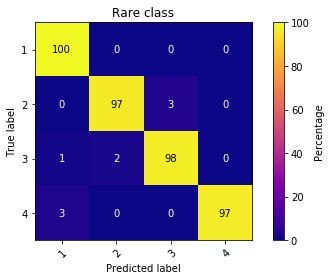

Flag True False S.America False
Mean Absolute Error: 0.63
Model Accuracy: 69.39
(array([1, 2, 3, 4, 5, 6]), array([31, 17, 35, 52, 39, 20]))
(array([1, 2, 3, 4, 5, 6]), array([24, 13, 26, 37, 32, 13]))
(array([1, 2, 3, 4, 5, 6]), array([ 7,  4,  9, 15,  7,  7]))


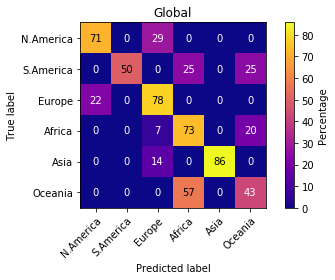

Mean Absolute Error: 0.59
Model Accuracy: 71.43
(array([1, 2, 3, 4, 5, 6]), array([31, 17, 35, 52, 39, 20]))
(array([1, 2, 3, 4, 5, 6]), array([24, 13, 26, 37, 32, 13]))
(array([1, 2, 3, 4, 5, 6]), array([ 7,  4,  9, 15,  7,  7]))


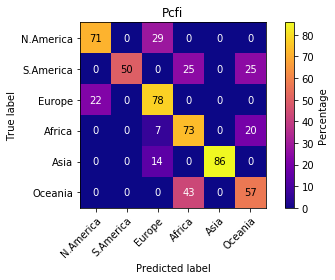

S.America
Mean Absolute Error: 0.55
Model Accuracy: 71.43
(array([1, 2, 3, 4, 5, 6]), array([31, 17, 35, 52, 39, 20]))
(array([1, 2, 3, 4, 5, 6]), array([24, 13, 26, 37, 32, 13]))
(array([1, 2, 3, 4, 5, 6]), array([ 7,  4,  9, 15,  7,  7]))


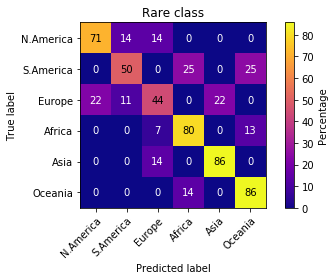

Tumor False False rectum False
Mean Absolute Error: 4.8
Model Accuracy: 34.15
(array([ 1,  2,  3,  4,  5,  7,  8, 11, 12, 13, 14, 17, 18, 19, 22]), array([82, 20,  9, 13, 39, 14,  6, 28, 16,  7, 24, 10, 29,  6, 24]))
(array([ 1,  2,  3,  4,  5,  7,  8, 11, 12, 13, 14, 17, 18, 19, 22]), array([63, 15,  8,  9, 26, 12,  4, 22, 10,  7, 15,  8, 24,  4, 18]))
(array([ 1,  2,  3,  4,  5,  7,  8, 11, 12, 14, 17, 18, 19, 22]), array([19,  5,  1,  4, 13,  2,  2,  6,  6,  9,  2,  5,  2,  6]))


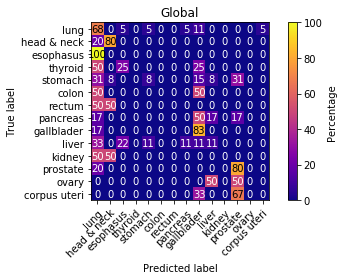

Mean Absolute Error: 6.15
Model Accuracy: 30.49
(array([ 1,  2,  3,  4,  5,  7,  8, 11, 12, 13, 14, 17, 18, 19, 22]), array([82, 20,  9, 13, 39, 14,  6, 28, 16,  7, 24, 10, 29,  6, 24]))
(array([ 1,  2,  3,  4,  5,  7,  8, 11, 12, 13, 14, 17, 18, 19, 22]), array([63, 15,  8,  9, 26, 12,  4, 22, 10,  7, 15,  8, 24,  4, 18]))
(array([ 1,  2,  3,  4,  5,  7,  8, 11, 12, 14, 17, 18, 19, 22]), array([19,  5,  1,  4, 13,  2,  2,  6,  6,  9,  2,  5,  2,  6]))


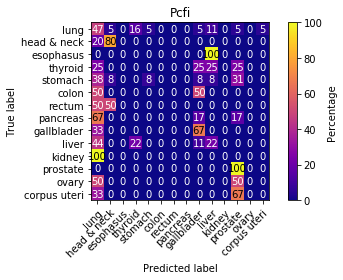

rectum
Mean Absolute Error: 7.04
Model Accuracy: 17.07
(array([ 1,  2,  3,  4,  5,  7,  8, 11, 12, 13, 14, 17, 18, 19, 22]), array([82, 20,  9, 13, 39, 14,  6, 28, 16,  7, 24, 10, 29,  6, 24]))
(array([ 1,  2,  3,  4,  5,  7,  8, 11, 12, 13, 14, 17, 18, 19, 22]), array([63, 15,  8,  9, 26, 12,  4, 22, 10,  7, 15,  8, 24,  4, 18]))
(array([ 1,  2,  3,  4,  5,  7,  8, 11, 12, 14, 17, 18, 19, 22]), array([19,  5,  1,  4, 13,  2,  2,  6,  6,  9,  2,  5,  2,  6]))


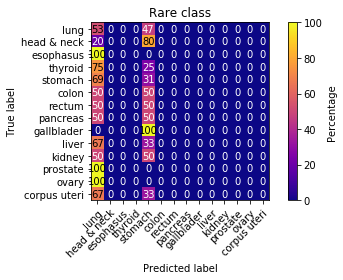

Cars True False vgood False
Mean Absolute Error: 0.27
Model Accuracy: 76.62
(array([0, 1, 2, 3]), array([1210,  384,   69,   65]))
(array([0, 1, 2, 3]), array([908, 288,  51,  49]))
(array([0, 1, 2, 3]), array([302,  96,  18,  16]))


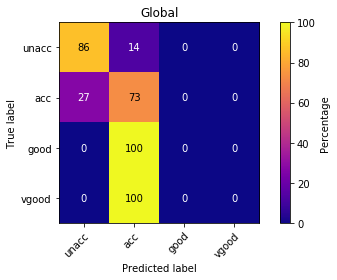

Mean Absolute Error: 0.27
Model Accuracy: 76.62
(array([0, 1, 2, 3]), array([1210,  384,   69,   65]))
(array([0, 1, 2, 3]), array([908, 288,  51,  49]))
(array([0, 1, 2, 3]), array([302,  96,  18,  16]))


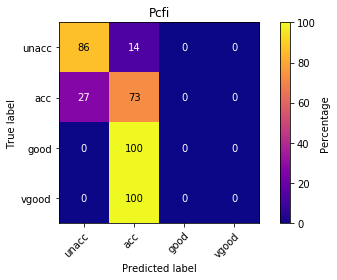

vgood
Mean Absolute Error: 0.4
Model Accuracy: 67.82
(array([0, 1, 2, 3]), array([1210,  384,   69,   65]))
(array([0, 1, 2, 3]), array([908, 288,  51,  49]))
(array([0, 1, 2, 3]), array([302,  96,  18,  16]))


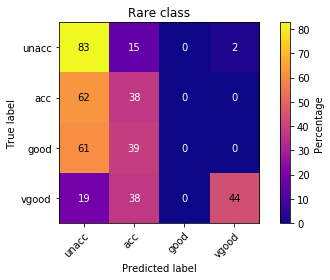

In [15]:
#CHECK THEY ARE DIFFERENT
RF_fits = [fit_RF(*data) for data in datasets]
top5_features = [f_top5(*(fits_y[:3])) for fits_y in RF_fits]
for k in range(len(datasets)):
    data = cp.deepcopy(datasets[k])
    label = data[0]
    f1, f2, f3, rare_class_ind, is_balanced = top5_features[k]
    print(label, all(lab in f1 for lab in f2), all(lab in f3 for lab in f2),
          RF_fits[k][-1][rare_class_ind], is_balanced)
    #print(f1)
    #print(f2)
    #print(f3)
    
    data[2] = f1
    fit_param = fit_RF(*data)
    fig, ax = plot_confusion_matrix(*(fit_param[-3:]),# y_test, predictions, class_names,
                      title='Global')
    #fig.savefig(fig_path+'/confusion_matrix_default_method.pdf', bbox_inches='tight')
    plt.show()
    
    data[2] = f2
    fit_param = fit_RF(*data)
    fig, ax = plot_confusion_matrix(*(fit_param[-3:]),# y_test, predictions, class_names,
                      title='Pcfi')
    #fig.savefig(fig_path+'/confusion_matrix_pcfi_method.pdf', bbox_inches='tight')
    plt.show()
    
    print(RF_fits[k][-1][rare_class_ind])
    data[2] = f3
    fit_param = fit_RF(*data)
    fig, ax = plot_confusion_matrix(*(fit_param[-3:]),# y_test, predictions, class_names,
                      title='Rare class')
    #fig.savefig(fig_path+'/confusion_matrix_rare_class_method.pdf', bbox_inches='tight')
    plt.show()